# LDDMM: how To Bring Deformations from Subject-Specific Atlases Into the Tangent Space at the Global Atlas

- Load meshes:
  - Use DenseMaternalMeshLoader to load left hippocampus structure for all three subjects

- Create subject-specific pre-pregnancy atlases:
  - For each subject i:
    - Get pre-pregnancy meshes of left hippocampus
    - Compute subject-specific pre-pregnancy atlas $X_{i, \text{pre-pregnancy}}$.

- Create global pre-pregnancy atlas:
  - Compute global pre-pregnancy atlas from subject-specific pre-pregnancy atlases: $X^{\text{pre-pregnancy}} = \text{mean}_i ~~X^{\text{pre-pregnancy}}_{i}$.

- Extract pregnancy deformations as momenta:
  - For each subject i and pregnancy timepoint t:
    - Compute deformation from pre-pregnancy atlas to each pregnancy mesh, using control points of global atlas: $\text{deformation}_{it} = X^{\text{pre-pregnancy}}_{i} \rightarrow X^{\text{pregnancy}}_{it}$ as momenta at control points
    - Parallel transport deformation into global deterministic atlas space to get Xit: this is assumed to be the identity

- Build prediction model:
  - Use linear regression to predict gestational week (Yit=t) from transported deformations (Xit)

In [1]:
import shutil
from pathlib import Path

import numpy as np
import pandas as pd
import pyvista as pv

import polpo.lddmm as plddmm
import polpo.preprocessing.dict as ppdict
import polpo.preprocessing.pd as ppd
import polpo.utils as putils
from polpo.plot.pyvista import RegisteredMeshesGifPlotter
from polpo.preprocessing.load.deformetrica import LoadMeshFlow
from polpo.preprocessing.load.pregnancy.jacobs import MeshLoader, TabularDataLoader
from polpo.preprocessing.mesh.decimation import PvDecimate
from polpo.preprocessing.mesh.io import DictMeshWriter, PvReader
from polpo.preprocessing.mesh.registration import RigidAlignment
from polpo.preprocessing.str import TryToInt

W1007 14:56:50.734000 29039 site-packages/torch/utils/cpp_extension.py:118] No CUDA runtime is found, using CUDA_HOME='/usr'


In [2]:
DEBUG = False
RECOMPUTE = True
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

In [3]:
SUBJECT_IDS = ["01", "1001B", "1004B"]

RESULTS_DIR = Path("results") / "regression_example"
ATLAS_DIR = RESULTS_DIR / "atlases"
MESHES_DIR = RESULTS_DIR / "meshes"
REGISTRATIONS_DIR = RESULTS_DIR / "registrations"
TRANSPORTS_DIR = RESULTS_DIR / "transports"
PARALLEL_SHOOT_DIR = RESULTS_DIR / "parallel_shoot"

if RESULTS_DIR.exists() and RECOMPUTE:
    shutil.rmtree(RESULTS_DIR)

data_dir = "/home/data/maternal" if putils.in_frank() else "~/.herbrain/data/maternal"

In [4]:
def _sub_id2name(sub_id):
    return f"sub_{sub_id}"

## Load, write and filter meshes

In [5]:
path2meshes = MeshLoader(
    subject_subset=SUBJECT_IDS,
    struct_subset=["L_Hipp"],
    as_mesh=True,
    data_dir=data_dir,
) + ppdict.ExtractUniqueKey(nested=True)


if DEBUG:
    path2meshes += ppdict.DictMap(ppdict.TruncateDict(n_keys=8))


# subject_id, session_id
raw_meshes = path2meshes()

print("Number of meshes for:")
for subject_id, meshes in raw_meshes.items():
    print(f"  -subject {subject_id}: {len(meshes)}")

Number of meshes for:
  -subject 01: 27
  -subject 1001B: 13
  -subject 1004B: 21


In [6]:
csvs = {}
for subject_id in SUBJECT_IDS:
    csvs[subject_id] = TabularDataLoader(data_dir=data_dir, subject_id=subject_id)()

for subject_id in SUBJECT_IDS:
    print(subject_id)
    display(csvs[subject_id])

01


,estro,prog,lh,gestWeek,stage,EndoStatus,trimester
sessionID,,,,,,,
1,NaN,NaN,NaN,-3.0,pre,pilot1,pre
2,3.42,0.840,NaN,-0.5,pre,pilot2,pre
3,386.00,NaN,NaN,1.0,pre,IVF,pre
4,1238.00,NaN,NaN,1.5,pre,IVF,pre
5,1350.00,2.940,NaN,2.0,pre,IVF,first
6,241.00,8.760,NaN,3.0,preg,Pregnant,first
7,NaN,NaN,NaN,9.0,preg,Pregnant,first
8,NaN,NaN,NaN,12.0,preg,Pregnant,first
9,NaN,NaN,NaN,14.0,preg,Pregnant,second


1001B


,gestWeek,stage,trimester,date
sessionID,,,,
base1,-18.0,pre,pre,4/1/2023
base2,-13.0,pre,pre,5/6/2023
gest1,8.0,preg,first,9/30/2023
gest2,13.0,preg,first,11/4/2023
gest3,17.0,preg,second,12/2/2023
gest4,22.0,preg,second,1/6/2024
gest5,26.0,preg,second,2/3/2024
gest6,30.0,preg,third,3/2/2024
gest7,35.0,preg,third,4/6/2024


1004B


,gestWeek,stage,trimester,date
sessionID,,,,
base1,-2.5,pre,pre,8/22/2023
base2,2.0,preg,first,9/21/2023
gest1,5.0,preg,first,10/11/2023
gest2,7.0,preg,first,10/26/2023
gest3,8.5,preg,first,11/7/2023
gest4,10.5,preg,first,11/20/2023
gest5,12.5,preg,first,12/4/2023
gest6,14.5,preg,second,12/18/2023
gest7,16.5,preg,second,1/3/2024


In [7]:
# Rigid alignment of all meshes to the first mesh of subject 01
align_pipe = RigidAlignment(
    target=putils.get_first(raw_meshes["01"]),
    # TODO: update here
    max_iterations=10,
)

# Coarsen all meshes to reduce number of vertices
# NB: this steps kills any correspondence between meshes
# TODO: evaluate relevance of this step
decimate_pipe = PvDecimate(target_reduction=0.6)


# TODO: it is better to go the other way around
rigidly_aligned_meshes = ppdict.DictMap(align_pipe)(raw_meshes)

meshes = ppdict.NestedDictMap(decimate_pipe)(rigidly_aligned_meshes)

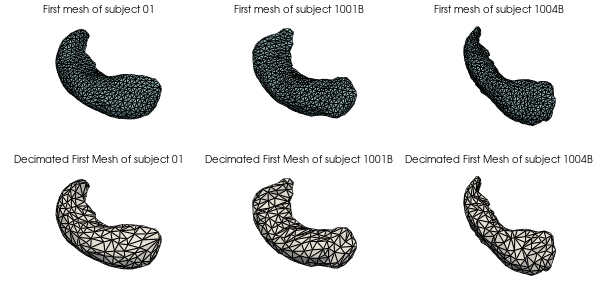

In [8]:
pl = pv.Plotter(shape=(2, 3), border=False, window_size=[600, 300])

for i, subject_id in enumerate(SUBJECT_IDS):
    pl.subplot(0, i)
    pl.add_mesh(putils.get_first(rigidly_aligned_meshes[subject_id]), show_edges=True)
    pl.add_text(
        f"First mesh of subject {subject_id}", position="upper_edge", font_size=4
    )

    pl.subplot(1, i)
    pl.add_mesh(putils.get_first(meshes[subject_id]), show_edges=True, color="white")
    pl.add_text(
        f"Decimated First Mesh of subject {subject_id}",
        position="upper_edge",
        font_size=4,
    )

pl.show()

In [9]:
def _key2name(key):
    sub_id, session_id = key.split("/")
    return f"{_sub_id2name(sub_id)}/mesh_{session_id}"


meshes2files = (
    ppdict.UnnestDict(sep="/")
    + DictMeshWriter(dirname=MESHES_DIR, ext="vtk", key2name=_key2name)
    + ppdict.NestDict(sep="/")
    + ppdict.DictMap(ppdict.DictMap(key_step=TryToInt()))
)

# subject, session: filename
dataset = meshes2files(meshes)

## Estimate deterministic atlas for subject and global

Compute subject specific deterministic atlas by averaging pre-pregnancy meshes.

First, we select the pre-pregnancy meshes.

In [10]:
# TODO: update here
pre_keys_selector = ppd.DfIsInFilter("stage", ["pre"]) + (lambda x: x.index)

pre_keys = ppdict.DictMap(pre_keys_selector)(csvs)

In [11]:
pre_dataset = {
    subject_id: ppdict.SelectKeySubset(pre_keys[subject_id])(meshes)
    for subject_id, meshes in dataset.items()
}

Closely follows [LDDMM: how to estimate a deterministic atlas?](./lddmm_deterministic_atlas.ipynb).

In [12]:
kernel_width = 10.0  # NB: influences the number of cp

registration_kwargs = dict(
    kernel_width=kernel_width,
    regularisation=1,
    max_iter=2000,
    freeze_control_points=False,
    metric="varifold",
    attachment_kernel_width=2.0,
    tol=1e-10,
)

In [13]:
templates = {}

for subject_id, dataset_ in pre_dataset.items():
    output_dir = ATLAS_DIR / _sub_id2name(subject_id)
    if output_dir.exists():
        templates[subject_id] = plddmm.io.load_template(output_dir, as_path=True)
        continue

    templates[subject_id] = plddmm.learning.estimate_deterministic_atlas(
        targets=dataset_,
        output_dir=output_dir,
        initial_step_size=1e-1,
        **registration_kwargs,
    )


output_dir = ATLAS_DIR / "global"
if not output_dir.exists():
    templates["global"] = plddmm.learning.estimate_deterministic_atlas(
        targets=templates,
        output_dir=output_dir,
        initial_step_size=1e-1,
        **registration_kwargs,
    )
else:
    templates["global"] = plddmm.io.load_template(output_dir, as_path=True)


templates = ppdict.DictMap(PvReader())(templates)

Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 10.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 10
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/regression_example/atlases/sub_01/deformetrica-state.p.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
{'max_iterations': 2000, 'freeze_template': False, 'freeze_control_points': False, 'freeze_momenta': False, 'use_sobolev_gradient': True, 'sobolev_kernel_width_ratio': 1, 'max_line_search_iterations': 50, 'initial_control_points': None, 'initial_cp_spacing': None, 'initial_momenta': None, 'dense_mode': False, 'number_of_threads': 1, 'print_every_n_iters': 20, 'downsampling_factor': 1, 'dimension': 3, 'optimization_method_type': 'ScipyLBFGS', 'convergence_toler

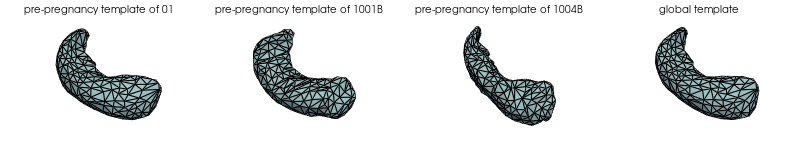

In [14]:
pl = pv.Plotter(shape=(1, 4), border=False, window_size=[800, 150])

for i, subject_id in enumerate(SUBJECT_IDS):
    pl.subplot(0, i)
    pl.add_mesh(templates[subject_id], show_edges=True)
    pl.add_text(
        f"pre-pregnancy template of {subject_id}", position="upper_edge", font_size=4
    )

pl.subplot(0, 3)
pl.add_mesh(templates["global"], show_edges=True)
pl.add_text("global template", position="upper_edge", font_size=4)

pl.show()

## Parallel transport to atlas

Closely follows [LDDMM: parallel transport?](./lddmm_transport_abc.ipynb).

In [15]:
global_template = plddmm.io.load_template(ATLAS_DIR / "global", as_path=True)

for subject_id, meshes in dataset.items():
    subject_template = plddmm.io.load_template(
        ATLAS_DIR / f"sub_{subject_id}", as_path=True
    )
    transport_dir = TRANSPORTS_DIR / _sub_id2name(subject_id)
    registrations_dir = REGISTRATIONS_DIR / _sub_id2name(subject_id)
    parallel_shoot_dir = PARALLEL_SHOOT_DIR / _sub_id2name(subject_id)

    for session_id, mesh in meshes.items():
        transport_dir_sess = transport_dir / plddmm.io.build_parallel_transport_name(
            subject_id, "global", session_id
        )
        if transport_dir_sess.exists():
            continue

        meshes = {
            "global": global_template,
            subject_id: subject_template,
            session_id: mesh,
        }
        plddmm.geometry.parallel_transport_ABC(
            meshes,
            output_dir=transport_dir,
            registration_dir=registrations_dir,
            compute_shoot=True,
            shoot_dir=parallel_shoot_dir,
            use_pole_ladder=True,
            **registration_kwargs,
        )

Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 20.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 10
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/regression_example/registrations/sub_01/01->global/deformetrica-state.p.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
instantiating kernel torch with kernel_width 20.0 and gpu_mode GpuMode.KERNEL. addr: 0x758560317b30
>> Set of 4 control points defined.
>> Momenta initialized to zero, for 1 subjects.
dtype=float32
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------
>> Gradient at Termination: 2076.6978893306127
>> ABNORMAL: 
>> Estimation took: 01

/home/luisfpereira/miniconda3/envs/deformetrica/lib/python3.12/site-packages/in_out/dataset_functions.py:265: UserWarning: Watch out, I did not get a distance type for the object shape, Please make sure you are running shooting or a parallel transport, otherwise distances are required.
  warnings.warn(msg)


>> Gradient at Termination: 1739.4395109621248
>> ABNORMAL: 
>> Estimation took: 00 seconds
Deformetrica.__del__()
source is ignored when pole ladder is used
In exponential update, I am not flowing because I don't have any template points to flow
In exponential update, I am not flowing because I don't have any template points to flow
[ compute_shooting function ]
Defaulting geodesic t0 to 1.
Defaulting geodesic tmax to 1.
Defaulting geodesic tmin to 0.
Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 20.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 10
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/regression_example/registrations/sub_01/01->3/deformetrica-state.p.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tri

## Visualize shooting from atlases to subject last mesh

From subject template.

In [16]:
meshes = {}

for subject_id, sessions in dataset.items():
    registrations_dir = (
        REGISTRATIONS_DIR
        / _sub_id2name(subject_id)
        / plddmm.io.build_registration_name(
            subject_id,
            list(sessions.keys())[-1],
        )
    )
    print(registrations_dir)
    meshes[subject_id] = plddmm.io.load_deterministic_atlas_flow(
        registrations_dir, as_pv=True
    )

results/regression_example/registrations/sub_01/01->27
results/regression_example/registrations/sub_1001B/1001B->post4
results/regression_example/registrations/sub_1004B/1004B->post6


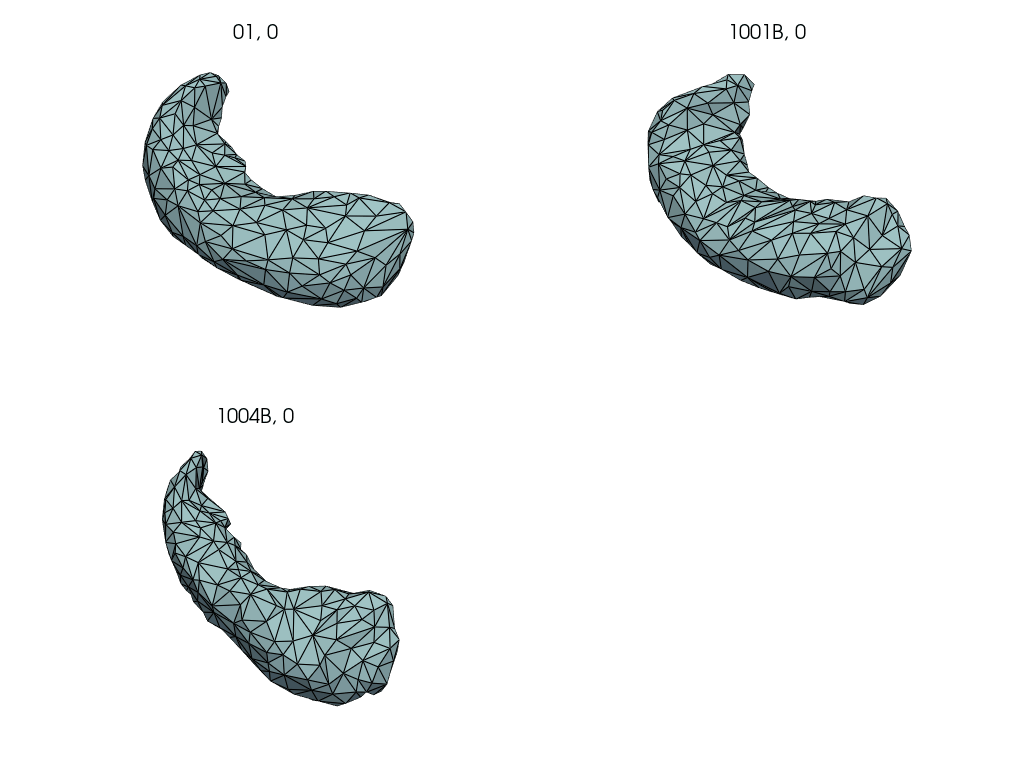

In [17]:
pl = RegisteredMeshesGifPlotter(
    subtitle=lambda time, subj: f"{subj}, {time}",
    shape=(2, 2),
    fps=5,
)

pl.add_meshes(ppdict.DictListSwapper()(meshes))
pl.close()

pl.show()

From global template.

In [18]:
meshes = {}

for subject_id, sessions in dataset.items():
    parallel_shoot_dir = (
        PARALLEL_SHOOT_DIR
        / _sub_id2name(subject_id)
        / plddmm.io.build_parallel_shoot_name(
            subject_id,
            "global",
            list(sessions.keys())[-1],
        )
    )
    print(parallel_shoot_dir)
    # TODO: clean io
    meshes[subject_id] = LoadMeshFlow(as_path=False)(parallel_shoot_dir)

results/regression_example/parallel_shoot/sub_01/global(t01>27)
results/regression_example/parallel_shoot/sub_1001B/global(t1001B>post4)
results/regression_example/parallel_shoot/sub_1004B/global(t1004B>post6)


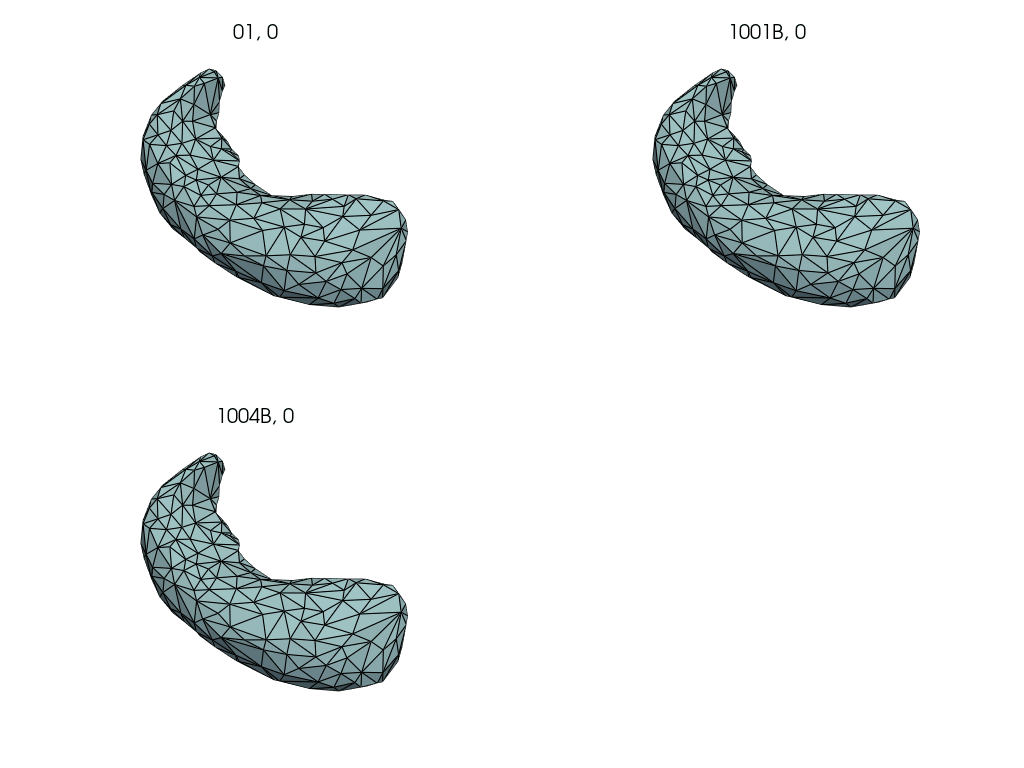

In [19]:
pl = RegisteredMeshesGifPlotter(
    subtitle=lambda time, subj: f"{subj}, {time}",
    shape=(2, 2),
    fps=5,
)

pl.add_meshes(ppdict.NestedDictSwapper()(meshes))
pl.close()

pl.show()

In [20]:
last_meshes = [list(meshes.values())[-1] for meshes in meshes.values()]

(
    np.amax(np.abs(last_meshes[0].points - last_meshes[1].points)),
    np.amax(np.abs(last_meshes[0].points - last_meshes[2].points)),
)

(np.float64(1.1753921508789062), np.float64(1.1911087036132812))

# Compute velocities

In [21]:
plddmm.io.load_cp(ATLAS_DIR / "global", as_path=True)

PosixPath('results/regression_example/atlases/global/DeterministicAtlas__EstimatedParameters__ControlPoints.txt')

In [22]:
cp = {}
momenta = {}
vel = {}

atlas_cp = plddmm.io.load_cp(ATLAS_DIR / "global", as_path=False)

for subject_id, meshes in dataset.items():
    transport_dir = TRANSPORTS_DIR / _sub_id2name(subject_id)
    cp_subj = cp[subject_id] = {}
    momenta_subj = momenta[subject_id] = {}
    vel_subj = vel[subject_id] = {}

    for session_id, mesh in meshes.items():
        transport_dir_sess = transport_dir / plddmm.io.build_parallel_transport_name(
            subject_id, "global", session_id
        )

        cp_ = cp_subj[session_id] = plddmm.io.load_transported_cp(
            transport_dir_sess, as_path=False
        )
        momenta_ = momenta_subj[session_id] = plddmm.io.load_transported_momenta(
            transport_dir_sess, as_path=False
        )

        vel_subj[session_id] = plddmm.geometry.velocity_at_x(
            atlas_cp, cp_, momenta_, kernel_width=kernel_width
        )

Velocities are comparable quantities.

In [23]:
vel_week = {}

for subject_id, subj_dict in vel.items():
    session2week = csvs[subject_id]["gestWeek"]
    vel_week[subject_id] = ppdict.DictMap(
        key_step=lambda session: float(session2week[session])
    )(vel[subject_id])

vel_ls = []
for subj_id, subj_vel in vel_week.items():
    for week, vels in subj_vel.items():
        vel_ls.append(
            {
                "subject": subj_id,
                "week": float(week),
                "vel": vels,
            }
        )

In [24]:
df = pd.DataFrame.from_dict(vel_ls)

df.to_csv(RESULTS_DIR / "velocities.csv", index=False)

In [ ]:
# Check that control points are the same across subjects
pl = pv.Plotter(shape=(1, 3), border=False, window_size=[1200, 300])

for i, subject_id in enumerate(SUBJECT_IDS):
    pl.subplot(0, i)
    pl.add_mesh(templates["global"], show_edges=True)
    cps = pv.PolyData(control_points[subject_id][0].cpu().numpy())
    pl.add_mesh(cps)
    # Add arrows at control points showing momenta
    # cps["vectors"] = momenta[subject_id][0].cpu().numpy()
    # pl.add_mesh(cps.glyph(orient="vectors", scale=False, factor=2),
    #             color="red", opacity=0.8)
    pl.add_text(
        f"deformation of first mesh of {subject_id} on global template",
        position="upper_edge",
        font_size=4,
    )


pl.show()
# Check that momenta are the same across subjects

In [ ]:
from sklearn.linear_model import LinearRegression

X = []
y = []

for subject_id in SUBJECT_IDS:
    # Get pregnancy indices from CSV files
    subject_csv = csvs[subject_id]
    subject_momenta = momenta[subject_id]
    assert len(subject_momenta) == len(subject_csv)
    pregnancy_indices = subject_csv.reset_index().index[subject_csv["stage"] == "preg"]
    # Select corresponding pre-pregnancy meshes
    pregnancy_momenta = [subject_momenta[i] for i in pregnancy_indices]
    pregnancy_gestweek = subject_csv["gestWeek"][
        subject_csv["stage"] == "preg"
    ].tolist()
    assert len(pregnancy_gestweek) == len(pregnancy_momenta)
    print(f"Found {len(pregnancy_momenta)} pregnancy momenta")
    y.extend(pregnancy_gestweek)
    X.extend(pregnancy_momenta)


X = np.array(X).reshape(len(y), -1)
y = np.array(y)

# Standardize y to have zero mean and unit variance
y = (y - np.mean(y)) / np.std(y)


print(X.shape)
print(y.shape)

In [ ]:
# Train-test split and regression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

regression = LinearRegression()
regression.fit(X_train, y_train)

train_r2 = regression.score(X_train, y_train)
test_r2 = regression.score(X_test, y_test)

print(f"Regression coefficients: {regression.coef_}")
print(f"Regression intercept: {regression.intercept_}")
print(f"Train R2 score: {train_r2:.3f}")
print(f"Test R2 score: {test_r2:.3f}")